In [ ]:
import os
import json
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Comparison logic requires statistical tests
from scipy.stats import ttest_rel, wilcoxon

In [9]:
# Cell 1: Imports and Configuration

# Set plot style for better visuals
sns.set_theme(style="whitegrid")

# --- Configuration ---

FAISS_INDEX_PATH = "../data/index/text_index.faiss"
METADATA_PATH = "../data/index/text_index_metadata.csv"
MODEL_NAME = "all-MiniLM-L6-v2"
TESTS_JSON_PATH = "../tests/baseline_robustness_tests.json"
TOP_K_DEFAULT = 10

# Helper to check paths
def check_paths():
    paths = [FAISS_INDEX_PATH, METADATA_PATH, TESTS_JSON_PATH]
    for p in paths:
        if not os.path.exists(p):
            print(f"[WARNING] File not found: {p}")
        else:
            print(f"[OK] Found: {p}")

check_paths()

[OK] Found: ../data/index/text_index.faiss
[OK] Found: ../data/index/text_index_metadata.csv
[OK] Found: ../tests/baseline_robustness_tests.json


In [10]:
def load_resources():
    """
    load FAISS index, metadata DataFrame, and MiniLM model.

    returns:
        index: FAISS index
        meta_df: DataFrame with columns ['uid', 'caption', 'image_path']
        model: SentenceTransformer model for query encoding
    """
    if not os.path.exists(FAISS_INDEX_PATH):
        raise FileNotFoundError(f"FAISS index not found at {FAISS_INDEX_PATH}")
    if not os.path.exists(METADATA_PATH):
        raise FileNotFoundError(f"Metadata CSV not found at {METADATA_PATH}")

    print("[INFO] Loading FAISS index from disk...")
    index = faiss.read_index(FAISS_INDEX_PATH)

    print("[INFO] Loading metadata from disk...")
    meta_df = pd.read_csv(METADATA_PATH)
    print(f"[INFO] Loaded metadata with {len(meta_df)} rows.")

    print(f"[INFO] Loading MiniLM model ({MODEL_NAME}) for query encoding...")
    model = SentenceTransformer(MODEL_NAME)

    return index, meta_df, model

In [11]:
def encode_and_normalize_query(model, query: str) -> np.ndarray:
    """
    encode a single query string with MiniLM and L2-normalize the embedding

    input:
        model: SentenceTransformer
        query: text string

    output:
        q_emb_norm: NumPy array of shape (1, D), dtype float32
    """
    q_emb = model.encode([query], show_progress_bar=False)
    norms = np.linalg.norm(q_emb, axis=1, keepdims=True) + 1e-12
    q_emb_norm = (q_emb / norms).astype("float32")
    return q_emb_norm


def cosine_similarity(model, q1: str, q2: str) -> float:
    """
    compute cosine similarity between two query strings
    using the same MiniLM encoder and L2-normalization.
    """
    emb1 = encode_and_normalize_query(model, q1)  # shape (1, D)
    emb2 = encode_and_normalize_query(model, q2)  # shape (1, D)

    # since they are normalized, cosine = dot product
    sim = float(np.dot(emb1[0], emb2[0]))
    return sim


def compute_cosine_similarity_drop(
    model,
    original_queries: list,
    perturbed_queries: list
) -> dict:
    """
    Compute cosine similarity drop between original and perturbed queries.
    
    Args:
        model: SentenceTransformer model
        original_queries: List of original query strings
        perturbed_queries: List of perturbed query strings (same length)
    
    Returns:
        {
            'similarities': list of floats,
            'mean_similarity': float,
            'mean_drop': float (1 - mean_similarity),
            'std_similarity': float,
            'min_similarity': float,
            'max_similarity': float
        }
    """
    if len(original_queries) != len(perturbed_queries):
        raise ValueError("Query lists must have same length")
    
    similarities = []
    for orig, pert in zip(original_queries, perturbed_queries):
        sim = cosine_similarity(model, orig, pert)
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    return {
        'similarities': similarities.tolist(),
        'mean_similarity': float(np.mean(similarities)),
        'mean_drop': float(1.0 - np.mean(similarities)),
        'std_similarity': float(np.std(similarities)),
        'min_similarity': float(np.min(similarities)),
        'max_similarity': float(np.max(similarities))
    }

In [12]:
def search(index, meta_df, model, query: str, top_k: int = TOP_K_DEFAULT):
    """
    run a text query against the FAISS index and return top k results

    inputs:
        index: FAISS index (IndexFlatIP with normalized embeddings)
        meta_df: DataFrame with metadata (uid, caption, image_path)
        model: MiniLM SentenceTransformer
        query: text query string
        top_k: number of results to return

    output:
        results: list of dicts like:
            {
                "rank": int,
                "idx": int,
                "uid": str,
                "caption": str,
                "score": float,
            }
    """
    q_emb_norm = encode_and_normalize_query(model, query)
    scores, indices = index.search(q_emb_norm, top_k)
    scores = scores[0]
    indices = indices[0]

    results = []
    for rank, (idx, score) in enumerate(zip(indices, scores), start=1):
        row = meta_df.iloc[idx]
        results.append(
            {
                "rank": rank,
                "idx": int(idx),
                "uid": row["uid"],
                "caption": row["caption"],
                "score": float(score),
            }
        )
    return results

In [13]:
def evaluate_random_subset(
    index,
    meta_df,
    model,
    num_samples: int = 100,
    top_k: int = 10,
    seed: int = 42,
):
    """
    evaluate retrieval performance on a random subset of captions.

    for each sampled row:
        - use its caption as the query
        - treat its UID as the "correct" asset
        - run search(top_k)
        - compute R@1, R@5, R@10 and Reciprocal Rank

    returns:
        dict with averaged metrics: R@1, R@5, R@10, MRR, num_samples
    """
    rng = np.random.default_rng(seed)
    n = len(meta_df)
    if num_samples > n:
        num_samples = n

    sampled_indices = rng.choice(n, size=num_samples, replace=False)

    r_at_1 = 0
    r_at_5 = 0
    r_at_10 = 0
    mrr_sum = 0.0
    individual_scores = []

    for count, idx in enumerate(sampled_indices, start=1):
        row = meta_df.iloc[idx]
        true_uid = row["uid"]
        query_caption = row["caption"]

        results = search(index, meta_df, model, query_caption, top_k=top_k)

        # find rank of the correct UID in the results
        rank_of_true = None
        for r in results:
            if r["uid"] == true_uid:
                rank_of_true = r["rank"]
                break

        individual_scores.append({
            'query': query_caption,
            'true_uid': true_uid,
            'rank': rank_of_true,
            'found_in_top1': rank_of_true == 1 if rank_of_true else False,
            'found_in_top5': rank_of_true <= 5 if rank_of_true else False,
            'found_in_top10': rank_of_true <= 10 if rank_of_true else False,
            'reciprocal_rank': 1.0 / rank_of_true if rank_of_true else 0.0
        })

        if rank_of_true is not None:
            if rank_of_true <= 1:
                r_at_1 += 1
            if rank_of_true <= 5:
                r_at_5 += 1
            if rank_of_true <= 10:
                r_at_10 += 1

            # Reciprocal Rank
            mrr_sum += 1.0 / rank_of_true

        if count % 10 == 0:
            print(f"[INFO] Processed {count}/{num_samples} samples...")

    num = float(num_samples)
    metrics = {
        "R@1": r_at_1 / num,
        "R@5": r_at_5 / num,
        "R@10": r_at_10 / num,
        "MRR": mrr_sum / num,
        "num_samples": num_samples,
        "individual_scores": individual_scores,
    }
    return metrics

In [14]:
def compute_robustness_ratio(
    index,
    meta_df,
    model,
    original_queries: list,
    perturbed_queries: list,
    ground_truth_uids: list,
    k_values: list = [1, 5, 10]
) -> dict:
    """
    Compute Robustness Ratio: RR = R@k(perturbed) / R@k(original).
    
    Args:
        index: FAISS index
        meta_df: Metadata DataFrame
        model: SentenceTransformer model
        original_queries: List of original query strings
        perturbed_queries: List of perturbed versions (same length)
        ground_truth_uids: List of correct UIDs for each query
        k_values: List of k values to test (default: [1, 5, 10])
    
    Returns:
        {
            'original': {'R@1': float, 'R@5': float, 'R@10': float},
            'perturbed': {'R@1': float, 'R@5': float, 'R@10': float},
            'robustness_ratios': {'RR@1': float, 'RR@5': float, 'RR@10': float},
            'num_queries': int
        }
    """
    if len(original_queries) != len(perturbed_queries) != len(ground_truth_uids):
        raise ValueError("All input lists must have same length")
    
    def compute_recall_at_k(queries, uids, k):
        """Helper: compute R@k for a set of queries."""
        hits = 0
        for query, true_uid in zip(queries, uids):
            results = search(index, meta_df, model, query, top_k=k)
            if any(r['uid'] == true_uid for r in results):
                hits += 1
        return hits / len(queries) if queries else 0.0
    
    # Compute R@k for original and perturbed queries
    results = {
        'original': {},
        'perturbed': {},
        'robustness_ratios': {},
        'num_queries': len(original_queries)
    }
    
    for k in k_values:
        r_orig = compute_recall_at_k(original_queries, ground_truth_uids, k)
        r_pert = compute_recall_at_k(perturbed_queries, ground_truth_uids, k)
        
        results['original'][f'R@{k}'] = r_orig
        results['perturbed'][f'R@{k}'] = r_pert
        results['robustness_ratios'][f'RR@{k}'] = r_pert / r_orig if r_orig > 0 else 0.0
    
    return results


def run_robustness_tests(index, meta_df, model, tests_path, top_ks=(1, 5, 10)):
    """
    Run robustness tests over a set of query families.

    tests: list of dicts, each like:
        {
            "name": str,
            "orig": str,
            "orig_type": str (optional, default "canonical"),
            "variants": [
                {"query": str, "type": str},
                ...
            ]
        }
    """
    
    with open(tests_path, "r", encoding="utf-8") as f:
        tests = json.load(f)


    max_k = max(top_ks)
    top_ks_sorted = sorted(top_ks)

    def classify_rank(rank):
        if rank is None:
            return "miss"
        for k in top_ks_sorted:
            if rank <= k:
                return f"R@{k}"
        return "miss"

    results = []

    def evaluate_query(query, query_type, variant_label, variant_type, target_uid, test_name):
        res = search(index, meta_df, model, query, top_k=max_k)

        rank = None
        for r in res:
            if r["uid"] == target_uid:
                rank = r["rank"]
                break

        success = classify_rank(rank)

        results.append(
            {
                "test_name": test_name,
                "query_type": query_type,        # "orig" or "variant"
                "variant_label": variant_label,  # "orig" or the variant query
                "variant_type": variant_type,    # e.g. "typo", "hypernym", etc.
                "query": query,
                "rank": rank,
                "success_level": success,
            }
        )

        return rank, success

    print("[INFO] Running robustness tests (R@1 / R@5 / R@10)...")

    # Collect data for aggregate metrics
    all_original_queries = []
    all_variant_queries = []
    all_target_uids = []

    for test in tests:
        name = test.get("name", "UNKNOWN_TEST")
        orig_query = test["orig"]
        orig_type = test.get("orig_type", "canonical")
        variants = test.get("variants", [])

        print("\n" + "-" * 80+"\n")
        print(f"[TEST] {name}")
        print(f"  Original query: {orig_query}")

        # determine target UID from original query (top-1 result)
        orig_results = search(index, meta_df, model, orig_query, top_k=max_k)
        orig_top = orig_results[0]
        target_uid = orig_top["uid"]
        print(
            "  [ORIG TOP-1] uid={}  score={:.4f}".format(
                target_uid, orig_top["score"]
            )
        )
        print("              caption: {}".format(orig_top["caption"]))

        # evaluate original query
        orig_rank, orig_level = evaluate_query(
            query=orig_query,
            query_type="orig",
            variant_label="orig",
            variant_type=orig_type,
            target_uid=target_uid,
            test_name=name,
        )
        print(f"\n  => Original: success={orig_level}  rank={orig_rank}  type={orig_type}")

        # pretty print variants in a table-like format
        if variants:
            print("\n  Variants:")
            # header
            print("    {succ:<7}  {rank:<4}  {vtype:<20}  {query}".format(
                succ="success",
                rank="rank",
                vtype="type",
                query="query",
            ))
            print("    {:-<7}  {:-<4}  {:-<20}  {:-<40}".format("", "", "", ""))

            for v in variants:
                q = v["query"]
                v_type = v.get("type", "unknown")

                rank_v, level_v = evaluate_query(
                    query=q,
                    query_type="variant",
                    variant_label=q,
                    variant_type=v_type,
                    target_uid=target_uid,
                    test_name=name,
                )

                rank_str = "-" if rank_v is None else str(rank_v)
                print(
                    "    {succ:<7}  {rank:<4}  {vtype:<20}  {query}".format(
                        succ=level_v,
                        rank=rank_str,
                        vtype=v_type[:20],
                        query=q,
                    )
                )
                
                # Collect for aggregate metrics
                all_original_queries.append(orig_query)
                all_variant_queries.append(q)
                all_target_uids.append(target_uid)

    # Compute aggregate metrics after all tests
    if all_variant_queries:
        print("\n" + "=" * 80)
        print("AGGREGATE METRICS (across all tests):")
        print("=" * 80)
        
        # Compute δSim
        delta_sim = compute_cosine_similarity_drop(
            model,
            all_original_queries,
            all_variant_queries
        )
        
        # Compute Robustness Ratio
        rr_metrics = compute_robustness_ratio(
            index, meta_df, model,
            all_original_queries,
            all_variant_queries,
            all_target_uids,
            k_values=[1, 5, 10]
        )
        
        print(f"\nCosine Similarity Drop (δSim):")
        print(f"  Mean similarity: {delta_sim['mean_similarity']:.4f}")
        print(f"  Mean drop (δSim): {delta_sim['mean_drop']:.4f}")
        print(f"  Std deviation:   {delta_sim['std_similarity']:.4f}")
        print(f"  Range:           [{delta_sim['min_similarity']:.4f}, {delta_sim['max_similarity']:.4f}]")
        
        print(f"\nRobustness Ratio (RR):")
        print(f"  Original R@1:  {rr_metrics['original']['R@1']:.3f}")
        print(f"  Perturbed R@1: {rr_metrics['perturbed']['R@1']:.3f}")
        print(f"  RR@1:          {rr_metrics['robustness_ratios']['RR@1']:.3f}")
        print(f"  RR@5:          {rr_metrics['robustness_ratios']['RR@5']:.3f}")
        print(f"  RR@10:         {rr_metrics['robustness_ratios']['RR@10']:.3f}")
        print(f"  Total queries: {rr_metrics['num_queries']}")

    return results

In [15]:
# load index, metadata, and text encoder
index, meta_df, model = load_resources()

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 678f2a20-854f-44e6-9a77-ff1184b777a8)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


[INFO] Loading FAISS index from disk...
[INFO] Loading metadata from disk...
[INFO] Loaded metadata with 10000 rows.
[INFO] Loading MiniLM model (all-MiniLM-L6-v2) for query encoding...


In [16]:
# quick sanity-check queries
test_queries = [
    "white sofa with wooden legs",
    "airplane",
]

for q in test_queries:
    print("\n" + "=" * 80)
    print(f"[QUERY] {q}")
    results = search(index, meta_df, model, q, top_k=5)
    for r in results:
        print(f"  {r['rank']}. uid={r['uid']}  score={r['score']:.4f}")
        print(f"     caption: {r['caption']}")


[QUERY] white sofa with wooden legs
  1. uid=53d0b31aa7f84bc4b1733224963d0114  score=0.9310
     caption: A white sofa with wooden legs and a wooden frame.
  2. uid=f761658fafcc42a78fd42912ef9f57e9  score=0.8172
     caption: A modern wooden sofa with white cushions and pillows, featuring a slatted backrest and solid legs.
  3. uid=69ed1dad032444cdb5bbb6fb883982e3  score=0.7854
     caption: A white sofa with curved features and an integrated wall light and shelf.
  4. uid=90be7242f24749c3a8e0b0a69c616fc1  score=0.7761
     caption: Brown leather Chesterfield sofa with metal legs.
  5. uid=d0b4812ad71b4d7f9eda54f48b65362a  score=0.7688
     caption: A white couch, bench, or sofa on a gray background.

[QUERY] airplane
  1. uid=ed60862e215a498a9a214ca51af1bf32  score=0.7869
     caption: A white airplane.
  2. uid=042f8ae68d594a0497d10b5f73e154d9  score=0.7335
     caption: A small blue airplane.
  3. uid=10891bcc6a924d33b0c38dda490f55ac  score=0.7335
     caption: A small blue airplan

In [17]:
# evaluation on a random subset
print("\n" + "=" * 80)
print("[INFO] Starting evaluation on random subset of captions...")

metrics = evaluate_random_subset(
    index,
    meta_df,
    model,
    num_samples=100,
    top_k=10,
)

print("\nEvaluation Summary ({} samples):".format(metrics["num_samples"]))
print("  R@1  = {:.3f}".format(metrics["R@1"]))
print("  R@5  = {:.3f}".format(metrics["R@5"]))
print("  R@10 = {:.3f}".format(metrics["R@10"]))
print("  MRR  = {:.3f}".format(metrics["MRR"]))


[INFO] Starting evaluation on random subset of captions...
[INFO] Processed 10/100 samples...
[INFO] Processed 20/100 samples...
[INFO] Processed 30/100 samples...
[INFO] Processed 40/100 samples...
[INFO] Processed 50/100 samples...
[INFO] Processed 60/100 samples...
[INFO] Processed 70/100 samples...
[INFO] Processed 80/100 samples...
[INFO] Processed 90/100 samples...
[INFO] Processed 100/100 samples...

Evaluation Summary (100 samples):
  R@1  = 0.990
  R@5  = 1.000
  R@10 = 1.000
  MRR  = 0.995


In [19]:
# small robustness check
robustness_results = run_robustness_tests(index, meta_df, model, TESTS_JSON_PATH)

[INFO] Running robustness tests (R@1 / R@5 / R@10)...

--------------------------------------------------------------------------------

[TEST] penguin
  Original query: A stylized purple penguin with a yellow beak, black wings and feet with yellow tips, and a gradient orange-yellow belly.
  [ORIG TOP-1] uid=1e00453a031940b48a4ea1ea16bb1a88  score=1.0000
              caption: A stylized purple penguin with a yellow beak, black wings and feet with yellow tips, and a gradient orange-yellow belly.

  => Original: success=R@1  rank=1  type=canonical

  Variants:
    success  rank  type                  query
    -------  ----  --------------------  ----------------------------------------
    miss     -     typo                  purple pgnguin
    R@1      1     paraphrase            stylized penguin with yellow beak
    R@5      3     filler                a cute small cartoon penguin with with wings and black eyes
    miss     -     synonym               A purple bird with wings
    mis

C:\Users\paabl\AppData\Local\Temp\ipykernel_14008\140771316.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_vals, ax=axes[0, 1], palette='viridis')
C:\Users\paabl\AppData\Local\Temp\ipykernel_14008\140771316.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_variants, x='variant_type', y='rank_val', ax=axes[1, 0], palette="Set2")


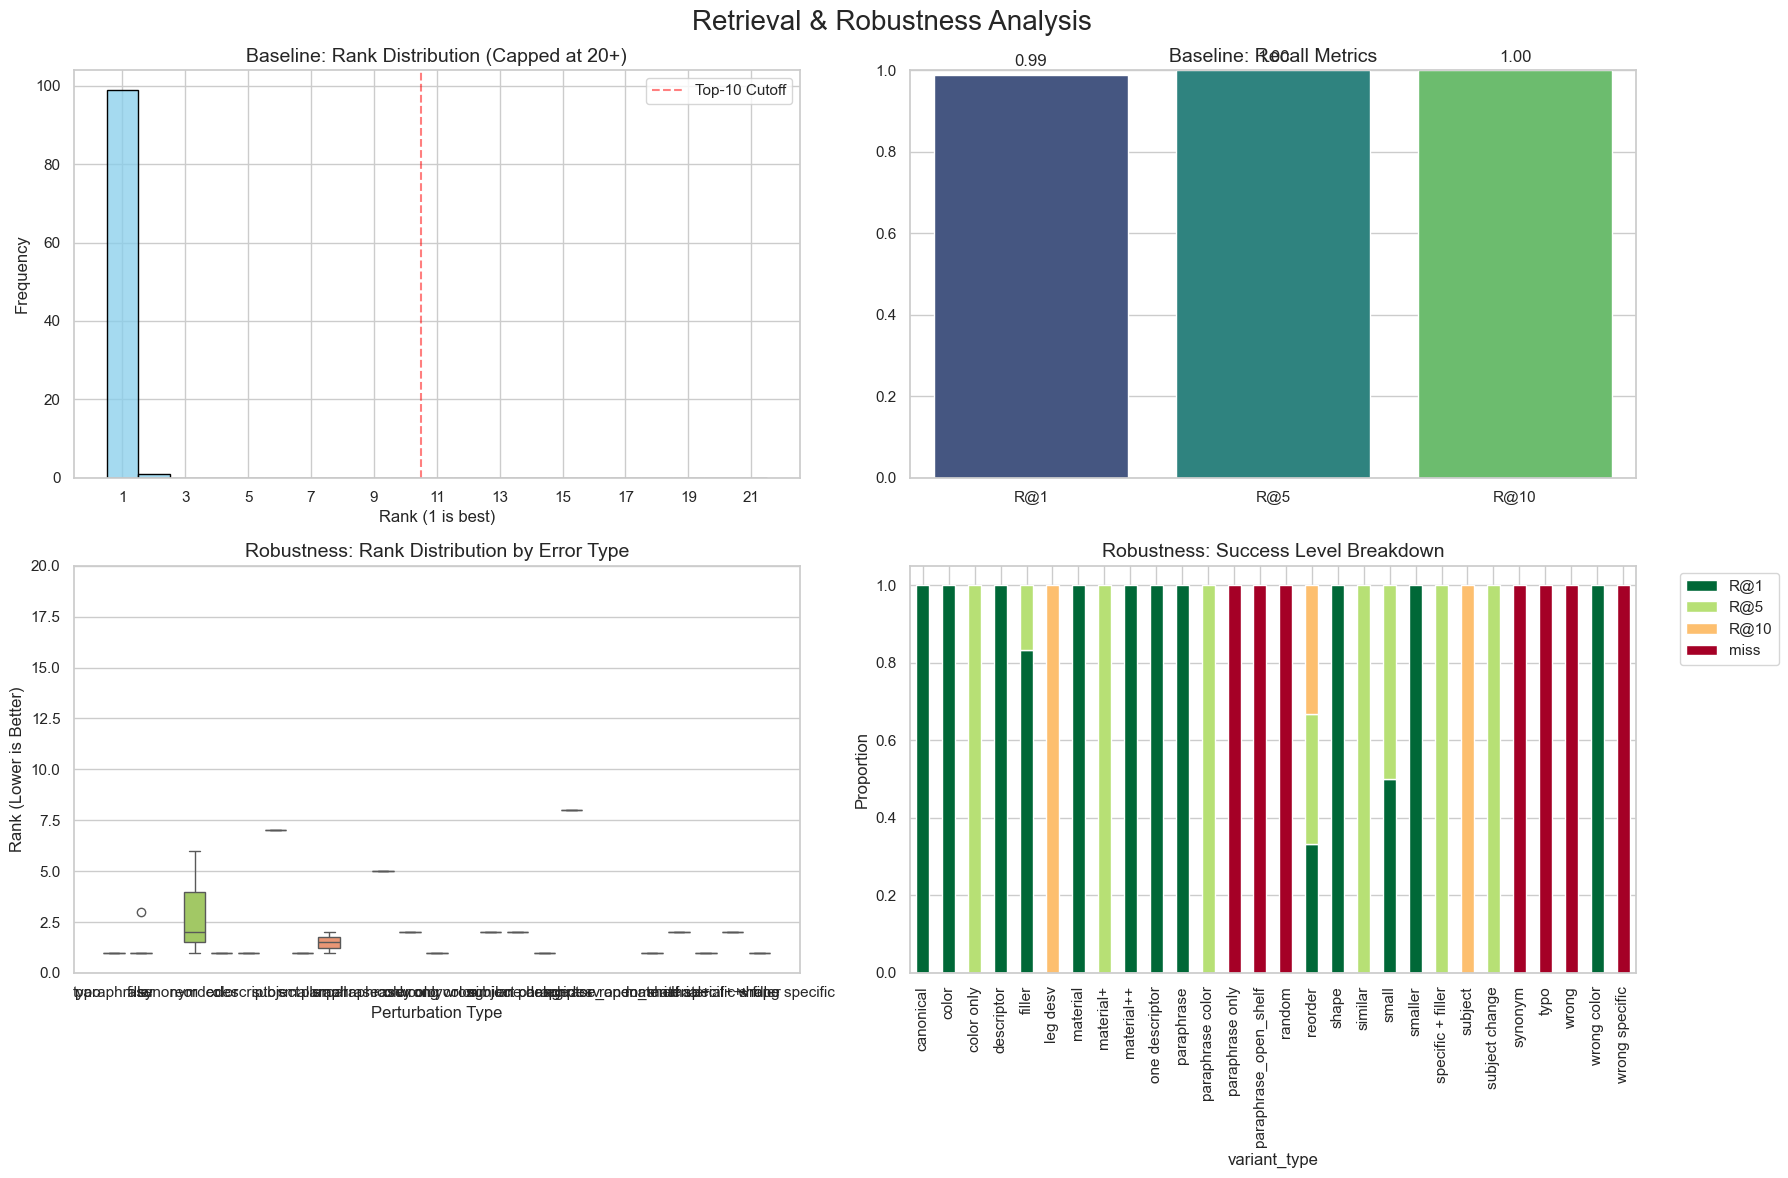

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set visual style
sns.set_theme(style="whitegrid")

def visualize_results(baseline_metrics, rob_results, model):
    """
    Generates a 2x2 dashboard of graphs from evaluation results.
    """
    
    # --- 1. PREPARE BASELINE DATA ---
    df_base = pd.DataFrame(baseline_metrics["individual_scores"])
    
    # Fill None ranks (misses) with a value slightly higher than top_k for plotting visibility
    max_rank_plot = 20 
    df_base['plot_rank'] = df_base['rank'].fillna(max_rank_plot + 5)
    df_base['plot_rank'] = df_base['plot_rank'].apply(lambda x: min(x, max_rank_plot + 1))

    # --- 2. PREPARE ROBUSTNESS DATA ---
    df_rob = pd.DataFrame(rob_results)
    
    # We need to link variants back to their originals to calculate similarity drops
    # Since the list is flat, we'll do a quick pass to compute similarity on the fly
    similarities = []
    
    # Create a lookup for original queries in this batch
    # (In a real scenario, we might want to pass the original query string in the result dict, 
    # but here we infer it or just compute sim against the specific test case orig)
    
    # Simplified approach: If type is 'orig', sim is 1.0. 
    # If variant, we compare to the 'variant_label' (which is the query) vs the Test's Original.
    # Note: To do this perfectly, we'd need the original query stored in the row. 
    # Let's approximate by assuming we just want to see Rank distribution by Type.
    
    # Handling Rank for plotting
    df_rob['rank_val'] = df_rob['rank'].fillna(50) # Cap misses at 50
    
    # --- PLOTTING ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Retrieval & Robustness Analysis', fontsize=20)

    # GRAPH 1: Baseline Rank Distribution (Histogram)
    sns.histplot(
        data=df_base, 
        x='plot_rank', 
        bins=np.arange(1, max_rank_plot + 3) - 0.5, 
        ax=axes[0, 0],
        color='skyblue',
        edgecolor='black'
    )
    axes[0, 0].set_title(f'Baseline: Rank Distribution (Capped at {max_rank_plot}+)', fontsize=14)
    axes[0, 0].set_xlabel('Rank (1 is best)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_xticks(range(1, max_rank_plot + 2, 2))
    axes[0, 0].axvline(x=10.5, color='red', linestyle='--', alpha=0.5, label='Top-10 Cutoff')
    axes[0, 0].legend()

    # GRAPH 2: Baseline Recall Metrics (Bar Chart)
    metrics_names = ['R@1', 'R@5', 'R@10']
    metrics_vals = [baseline_metrics['R@1'], baseline_metrics['R@5'], baseline_metrics['R@10']]
    
    sns.barplot(x=metrics_names, y=metrics_vals, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Baseline: Recall Metrics', fontsize=14)
    axes[0, 1].set_ylim(0, 1.0)
    for i, v in enumerate(metrics_vals):
        axes[0, 1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

    # GRAPH 3: Robustness - Rank Distribution by Perturbation Type (Box Plot)
    # Filter out 'orig' to see only the variants' performance
    df_variants = df_rob[df_rob['query_type'] == 'variant']
    
    if not df_variants.empty:
        sns.boxplot(data=df_variants, x='variant_type', y='rank_val', ax=axes[1, 0], palette="Set2")
        axes[1, 0].set_title('Robustness: Rank Distribution by Error Type', fontsize=14)
        axes[1, 0].set_ylabel('Rank (Lower is Better)')
        axes[1, 0].set_xlabel('Perturbation Type')
        axes[1, 0].set_ylim(0, 20) # Focus on top 20
    else:
        axes[1, 0].text(0.5, 0.5, "No variants data found", ha='center')

    # GRAPH 4: Robustness - Success Rate (Stacked Bar)
    # success_level contains 'R@1', 'R@5', 'miss', etc.
    # Let's aggregate by Type
    cross_tab = pd.crosstab(df_rob['variant_type'], df_rob['success_level'])
    
    # Normalize to get percentages
    cross_tab_prop = cross_tab.div(cross_tab.sum(1), axis=0)
    
    # Reorder columns logically if possible
    desired_order = ['R@1', 'R@5', 'R@10', 'miss']
    cols = [c for c in desired_order if c in cross_tab_prop.columns]
    cross_tab_prop = cross_tab_prop[cols]

    cross_tab_prop.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='RdYlGn_r')
    axes[1, 1].set_title('Robustness: Success Level Breakdown', fontsize=14)
    axes[1, 1].set_ylabel('Proportion')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Run the visualization
if 'metrics' in locals() and 'robustness_results' in locals():
    visualize_results(metrics, robustness_results, model)
else:
    print("Metrics or Robustness Results not found. Please run the previous cells first.")